In [1]:
!pip install ..

Processing c:\users\galoisuser\csaf
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for csaf: filename=csaf-0.0.1-py3-none-any.whl size=440771 sha256=4e3161e7a61c9c6021db5c94072a72adc2105d7b27c4401130a847abbae8f2b4
  Stored in directory: C:\Users\galoisuser\AppData\Local\Temp\pip-ephem-wheel-cache-l40kou2w\wheels\cc\d8\a7\fea95a0671dd3a5eb6f370100bcf39e2cd61662473ae48702e
Successfully built csaf
  Attempting uninstall: csaf
    Found existing installation: csaf 0.0.1
    Uninstalling csaf-0.0.1:
      Successfully uninstalled csaf-0.0.1


  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


In [2]:
import numpy as np

import sys
sys.path.append("..")
sys.path.append("csaf/core")

import csaf
import matplotlib.pyplot as plt
from csaf_f16 import fgnetfdm, fgintruder

from csaf_f16.goals import AcasSimpleCollideWithBalloonGoal
from csaf_f16.goals import AcasSimpleCollideAvoidBalloonGoal
from csaf_f16.goals import AcasShieldAvoidBalloonGoal
from csaf_f16.goals import AcasAirspeedAvoidNoBalloonGoal
from csaf_f16.goals import AcasAirspeedCollideNoBalloonGoal
from csaf_f16.ngoals import AcasAirportCollideGoal
from csaf_f16.ngoals import AcasRejoinCollideGoal
from csaf_f16.ngoals import AcasHeadOnCollideGoal
from csaf_f16.ngoals import AcasRejoinScenario

from csaf_f16.acas import AcasScenarioViewer

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
def closest_point(trajs):
    # Find the point of closest contact
    ownship = trajs['plant']['states']
    intruder = trajs['intruder_plant']['states']

    d_min = np.inf
    d_idx = 0
    for idx in range(0,min(len(ownship),len(intruder))):
        pn_o = ownship[idx][9]
        pe_o = ownship[idx][10]
        pn_i = intruder[idx][9]
        pe_i = intruder[idx][10]
        d = np.sqrt((pn_o -pn_i)**2 + (pe_o - pe_i)**2)
        if d < d_min:
            d_min = d
            d_idx = idx

    pn_0 = ownship[d_idx][9]
    pe_0 = ownship[d_idx][10]
    print(f"D_min={d_min}, idx={d_idx}, pn_0 = {pn_0},pe_0={pe_0}")
    return pn_0, pe_0

def get_camera(trajs, pn_0, pe_0):
    # Place camera
    import copy
    camera = copy.deepcopy(trajs['balloon'])
    for state in camera.states:
        state[9] = pn_0
        state[10] = pe_0
    trajs['camera'] = camera
    return trajs

In [4]:
f16a = fgnetfdm.FGNetFDM(h0_m=1500)
f16b = fgintruder.FGIntruder(callsign='F-16B', model_path='Aircraft/f16/Models/F-16.xml', fallback_model_index=516)
#balloon = fgintruder.FGIntruder(callsign='Balloon', model_path='Aircraft/Hot-Air-Balloon/Models/Hot-Air-Balloon.xml', fallback_model_index=702)
#camera = fgintruder.FGIntruder(callsign='Camera', model_path='Aircraft/ufo/Models/ufo.xml', fallback_model_index=712)

In [5]:
f16a.start()
f16b.start()
#balloon.start()
#camera.start()

<FGNetFDM> Starting main loop!
<FGIntruder> Starting main loop!


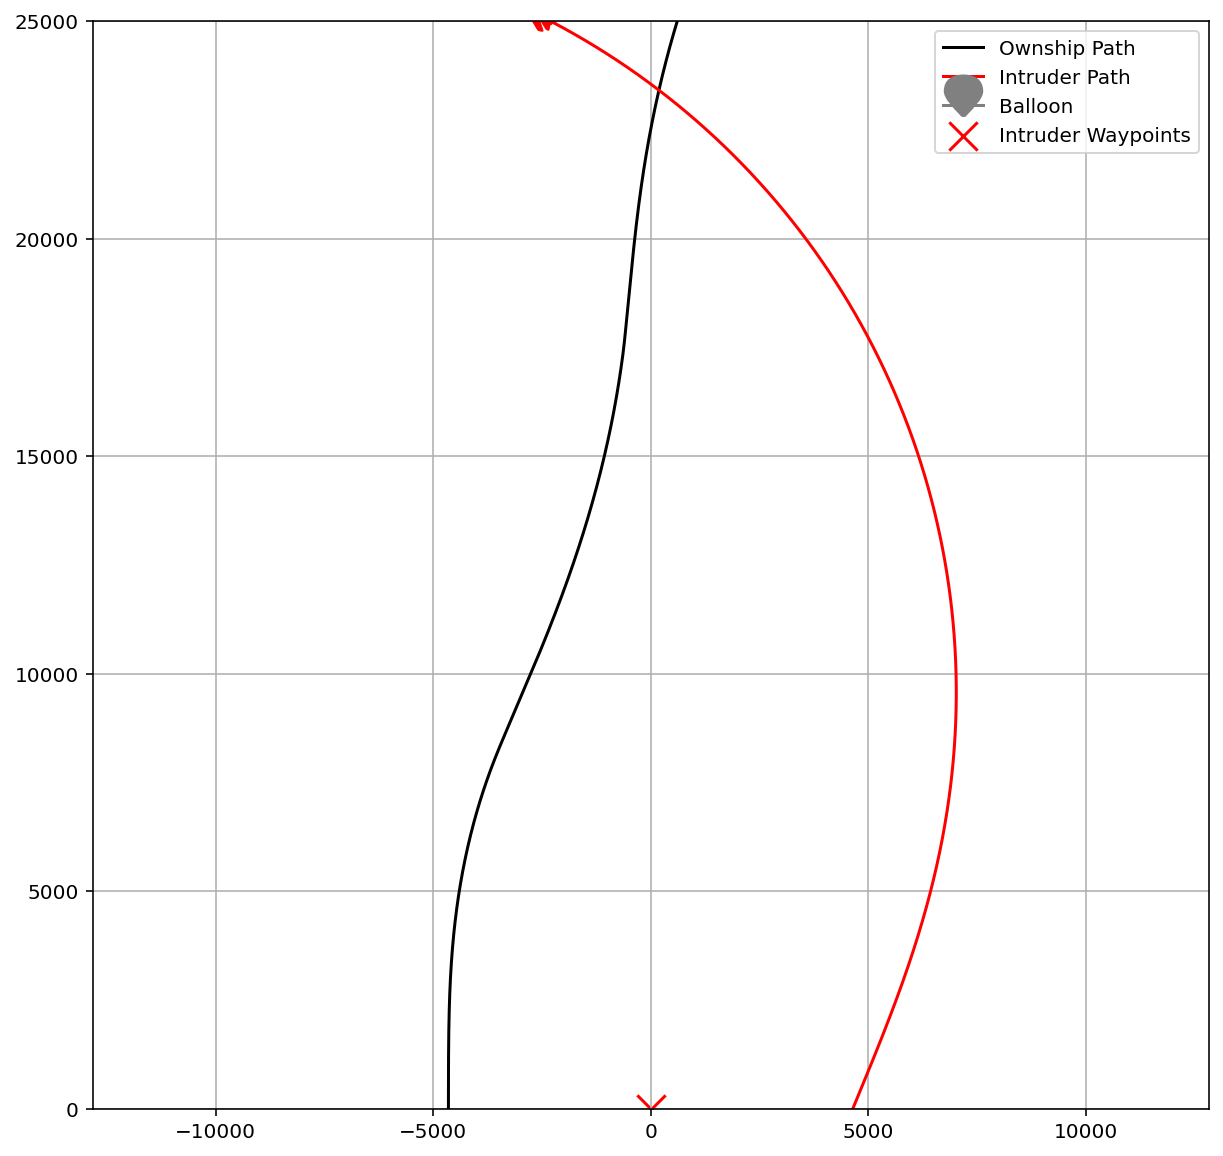

<Figure size 720x720 with 0 Axes>

D_min=401.9733183532272, idx=726, pn_0 = 23157.167712121278,pe_0=132.05040745578182


In [6]:
#g = AcasSimpleCollideWithBalloonGoal()
#g = AcasSimpleCollideAvoidBalloonGoal()
#g = AcasShieldAvoidBalloonGoal()
#g = AcasAirspeedAvoidNoBalloonGoal()
#g = AcasAirspeedCollideNoBalloonGoal()

#g = AcasHeadOnCollideGoal()
#g = AcasRejoinCollideGoal()
#g.scenario_type = AcasRejoinScenario
g = AcasAirportCollideGoal()

sys = g.scenario_type().generate_system(g.fixed_configurations[0])
trajs = sys.simulate_tspan((0.0, 27.0))
#trajs, p = g.run_sim(g.fixed_configurations[0])

scen = g.scenario_type()
viewer = AcasScenarioViewer(trajs, scen)
fig, ax = viewer.summary_plot()
ax.set_xlim(-10000, 10000)
ax.set_ylim(0, 25000)
plt.show()

pn_0,pe_0 = closest_point(trajs)
trajs = get_camera(trajs, pn_0, pe_0)



# Properly prepare the intruders
f16a.set_trajs(trajs['plant'],trajs['llc'])
f16b.set_trajs(trajs['intruder_plant'],trajs['intruder_llc'])
# LLC for balloon doesn't matter
#balloon.set_trajs(trajs['balloon'],trajs['llc'])
#camera.set_trajs(trajs['camera'],trajs['llc'])



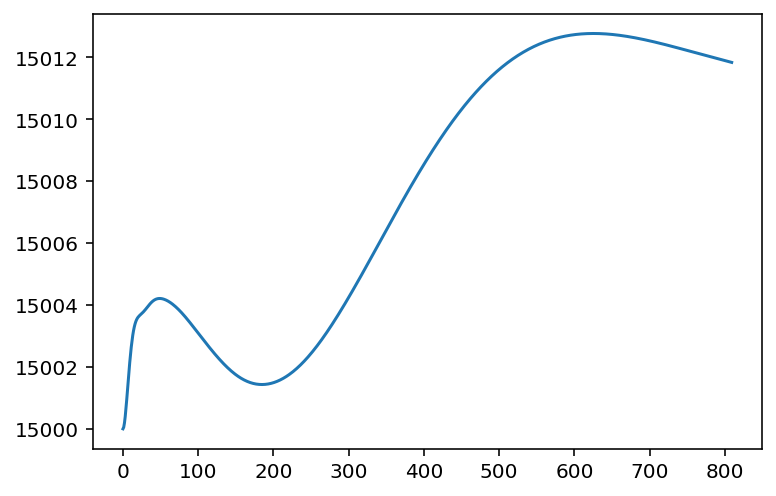

In [7]:
#plt.plot(np.array(trajs['intruder_plant'].states)[:, 9])
plt.plot(np.array(trajs['intruder_plant'].states)[:, 11])

In [8]:
f16a.reset()
f16b.reset()
#balloon.reset()
#camera.reset()

In [10]:
# Run the simulation
f16a.simulate(delta_t=0.01,speed=1.0)
f16b.simulate(delta_t=1.5,speed=1.0)

#balloon.simulate(delta_t=0.5,speed=0.9)
#camera.simulate(delta_t=0.01,speed=0.9)

In [ ]:
f16a.stop()
f16b.stop()
#balloon.stop()
#camera.stop()

In [ ]:
trajs['intruder_plant'].times